# Inter-projects data integration

In this tutorial we will integrate multiple single cell RNA-seq datasets.
The methods will include batch effect correction across datasets. We also check quantitative measures of the quality of our integration process.

References
* https://satijalab.org/seurat/articles/integration_introduction.html


Dataset used
* https://www.cell.com/cell/fulltext/S0092-8674(19)30559-8

In [34]:
suppressPackageStartupMessages({
    library(Seurat)
    library(SeuratData)
    library(patchwork)
    library(ggplot2)
    library(cowplot)
    theme_set(theme_cowplot())
    
    #library(SeuratWrappers)
    #library(tidyverse)
    #library(reticulate)
    #library(MAST)
    #library(velocyto.R)
    #library(monocle3)
    #library(magrittr)
})
options(warn=-1)

In [4]:
# install dataset
InstallData("ifnb")

In [5]:
# load dataset
LoadData("ifnb")

# split the dataset into a list of two seurat objects (stim and CTRL)
ifnb.list <- SplitObject(ifnb, split.by = "stim")
ifnb.list

# normalize and identify variable features for each dataset independently
ifnb.list <- lapply(X = ifnb.list, FUN = function(x) {
    x <- NormalizeData(x)
    x <- FindVariableFeatures(x, selection.method = "vst", nfeatures = 2000)
})

# select features that are repeatedly variable across datasets for integration
features <- SelectIntegrationFeatures(object.list = ifnb.list)

An object of class Seurat 
14053 features across 13999 samples within 1 assay 
Active assay: RNA (14053 features, 0 variable features)

# CCA method

In [6]:
# Perform integration

# The function FindIntegrationAnchors() uses a list of Seurat objects as input to identify 'anchors' 
# between two datasets.



immune.anchors <- FindIntegrationAnchors(object.list = ifnb.list, anchor.features = features)

Scaling features for provided objects

Finding all pairwise anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 16393 anchors

Filtering anchors

	Retained 6756 anchors



In [7]:
# this command creates an 'integrated' data assay
immune.combined <- IntegrateData(anchorset = immune.anchors)

Merging dataset 1 into 2

Extracting anchors for merged samples

Finding integration vectors

Finding integration vector weights

Integrating data



In [8]:
# specify that we will perform downstream analysis on the corrected data note that the
# original unmodified data still resides in the 'RNA' assay
DefaultAssay(immune.combined) <- "integrated"

# Run the standard workflow for visualization and clustering
immune.combined <- ScaleData(immune.combined, verbose = FALSE)
immune.combined <- RunPCA(immune.combined, npcs = 30, verbose = FALSE)
immune.combined <- RunUMAP(immune.combined, reduction = "pca", dims = 1:30)
immune.combined <- FindNeighbors(immune.combined, reduction = "pca", dims = 1:30)
immune.combined <- FindClusters(immune.combined, resolution = 0.5)

18:48:31 UMAP embedding parameters a = 0.9922 b = 1.112

18:48:31 Read 13999 rows and found 30 numeric columns

18:48:31 Using Annoy for neighbor search, n_neighbors = 30

18:48:31 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

18:48:33 Writing NN index file to temp file /tmp/Rtmpjh69HS/filedfab140052d

18:48:34 Searching Annoy index using 1 thread, search_k = 3000

18:48:40 Annoy recall = 100%

18:48:40 Commencing smooth kNN distance calibration using 1 thread

18:48:42 Initializing from normalized Laplacian + noise

18:48:43 Commencing optimization for 200 epochs, with 617842 positive edges

18:48:51 Optimization finished

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 13999
Number of edges: 569104

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9058
Number of communities: 14
Elapsed time: 2 seconds


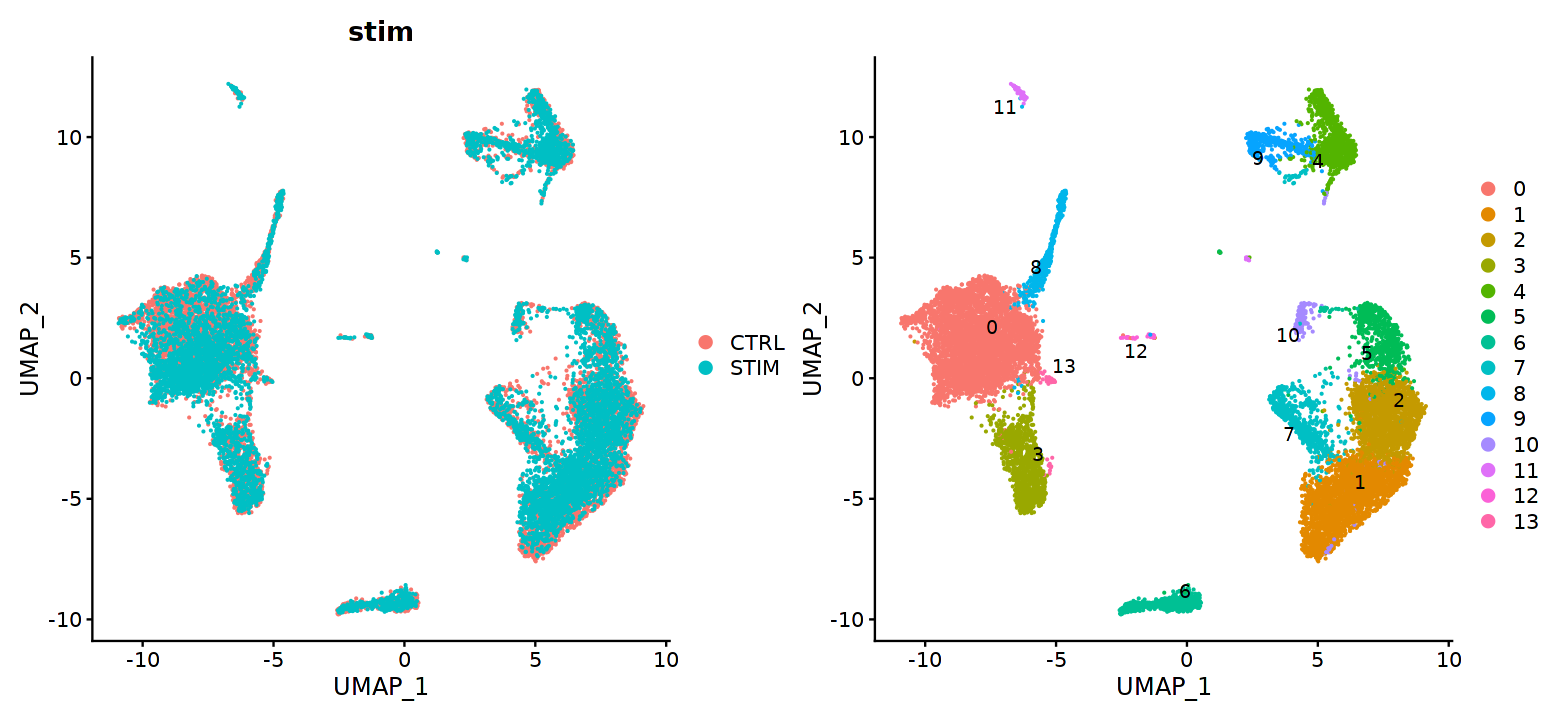

In [12]:
# Visualization
p1 <- DimPlot(immune.combined, reduction = "umap", group.by = "stim")
p2 <- DimPlot(immune.combined, reduction = "umap", label = TRUE, repel = TRUE)

options(repr.plot.width = 13, repr.plot.height = 6)
p1 + p2

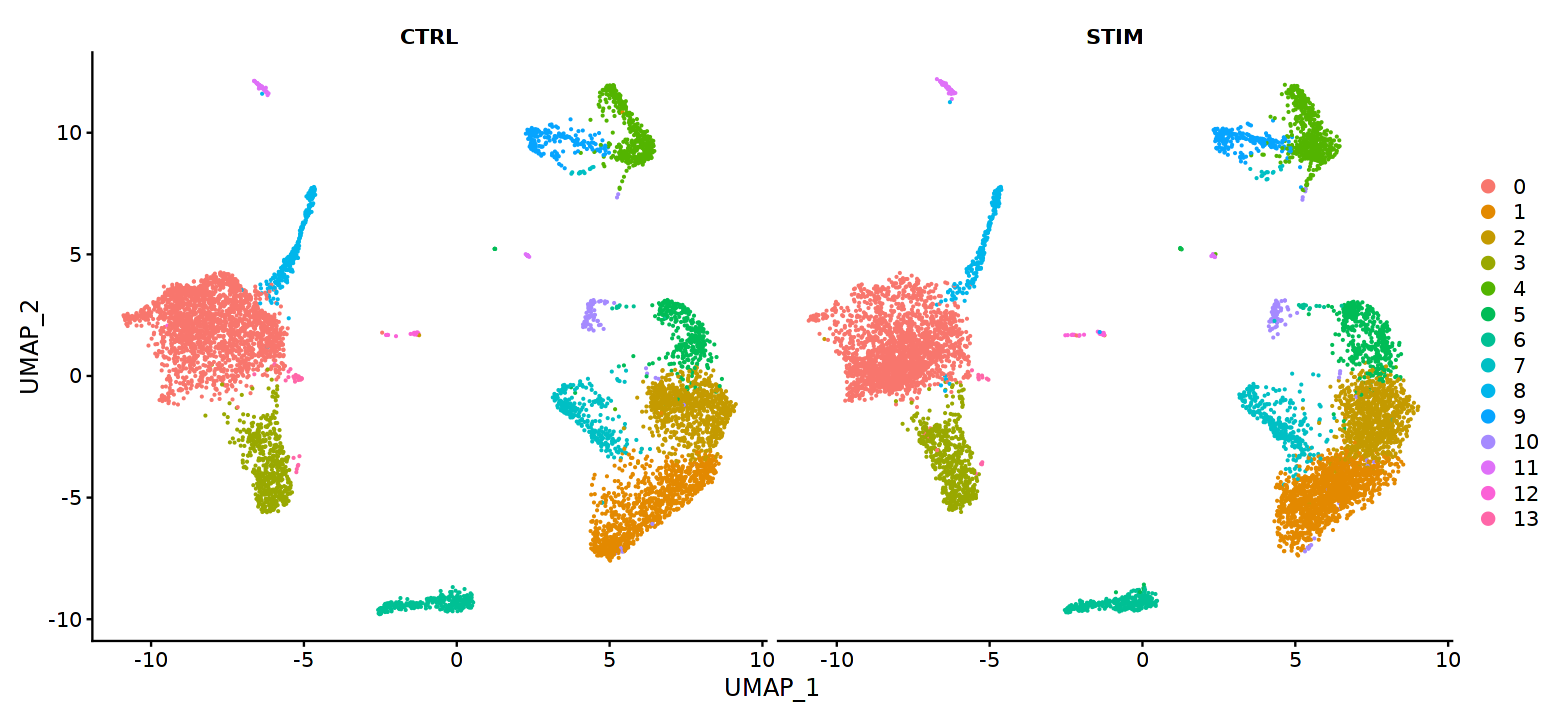

In [13]:
options(repr.plot.width = 13, repr.plot.height = 6)
DimPlot(immune.combined, reduction = "umap", split.by = "stim")

## Identify conserved cell type markers
To identify canonical cell type marker genes that are conserved across conditions, we provide the FindConservedMarkers() function. This function performs differential gene expression testing for each dataset/group and combines the p-values using meta-analysis methods from the MetaDE R package. For example, we can calculated the genes that are conserved markers irrespective of stimulation condition in cluster 6 (NK cells).

In [14]:
# For performing differential expression after integration, we switch back to the original
# data
DefaultAssay(immune.combined) <- "RNA"
nk.markers <- FindConservedMarkers(immune.combined, ident.1 = 6, grouping.var = "stim", verbose = FALSE)
head(nk.markers)

,CTRL_p_val,CTRL_avg_log2FC,CTRL_pct.1,CTRL_pct.2,CTRL_p_val_adj,STIM_p_val,STIM_avg_log2FC,STIM_pct.1,STIM_pct.2,STIM_p_val_adj,max_pval,minimump_p_val
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
GNLY,0,6.006173,0.944,0.045,0,0.000000e+00,5.863176,0.957,0.059,0.000000e+00,0.000000e+00,0
FGFBP2,0,3.243588,0.505,0.020,0,1.603755e-161,2.183999,0.258,0.015,2.253757e-157,1.603755e-161,0
CLIC3,0,3.461957,0.597,0.024,0,0.000000e+00,3.535807,0.622,0.031,0.000000e+00,0.000000e+00,0
PRF1,0,2.650548,0.422,0.017,0,0.000000e+00,4.098949,0.865,0.057,0.000000e+00,0.000000e+00,0
CTSW,0,2.987507,0.531,0.029,0,0.000000e+00,3.132129,0.594,0.035,0.000000e+00,0.000000e+00,0
KLRD1,0,2.777231,0.495,0.019,0,0.000000e+00,2.861043,0.551,0.027,0.000000e+00,0.000000e+00,0


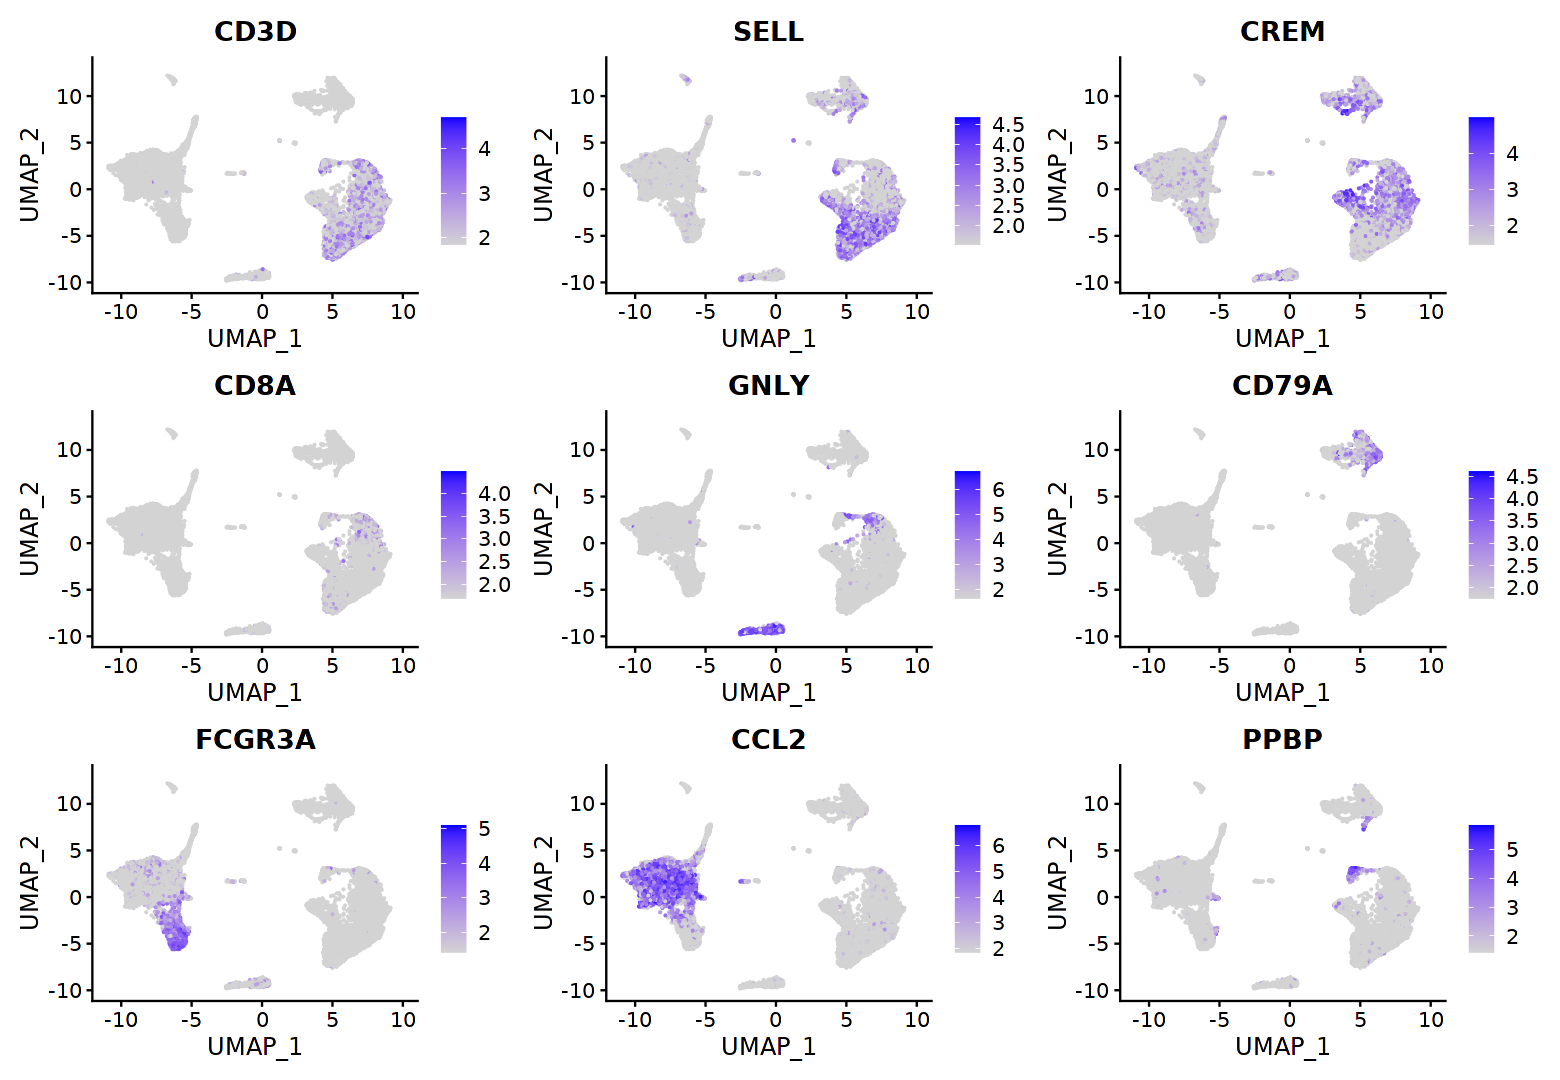

In [16]:
options(repr.plot.width = 13, repr.plot.height = 9)
FeaturePlot(immune.combined, features = c("CD3D", "SELL", "CREM", "CD8A", "GNLY", "CD79A", "FCGR3A",
    "CCL2", "PPBP"), min.cutoff = "q9")

In [20]:
immune.combined <- RenameIdents(immune.combined, 
                                `0` = "CD14 Mono", 
                                `1` = "CD4 Naive T", 
                                `2` = "CD4 Memory T",
                                `3` = "CD16 Mono", 
                                `4` = "B", 
                                `5` = "CD8 T", 
                                `6` = "NK", 
                                `7` = "T activated", 
                                `8` = "DC", 
                                `9` = "B Activated",
                                `10` = "Mk", 
                                `11` = "pDC", 
                                `12` = "Eryth", 
                                `13` = "Mono/Mk Doublets", 
                                `14` = "HSPC")

ERROR: Error in RenameIdents.Seurat(immune.combined, `0` = "CD14 Mono", `1` = "CD4 Naive T", : Cannot find any of the provided identities


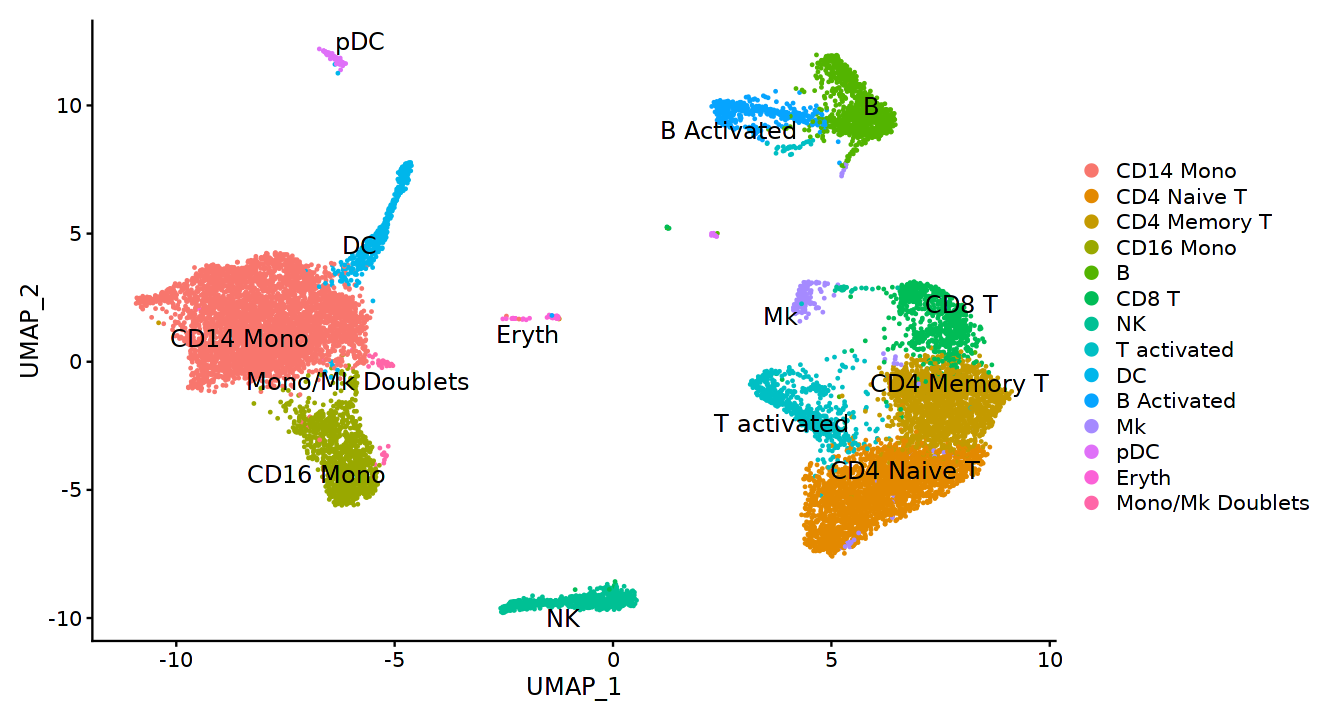

In [30]:
options(repr.plot.width = 11, repr.plot.height = 6)
DimPlot(immune.combined, label = TRUE, pt.size = 0.3, label.size = 5, repel = TRUE)

The DotPlot() function with the split.by parameter can be useful for viewing conserved cell type markers across conditions, showing both the expression level and the percentage of cells in a cluster expressing any given gene. Here we plot 2-3 strong marker genes for each of our 14 clusters.

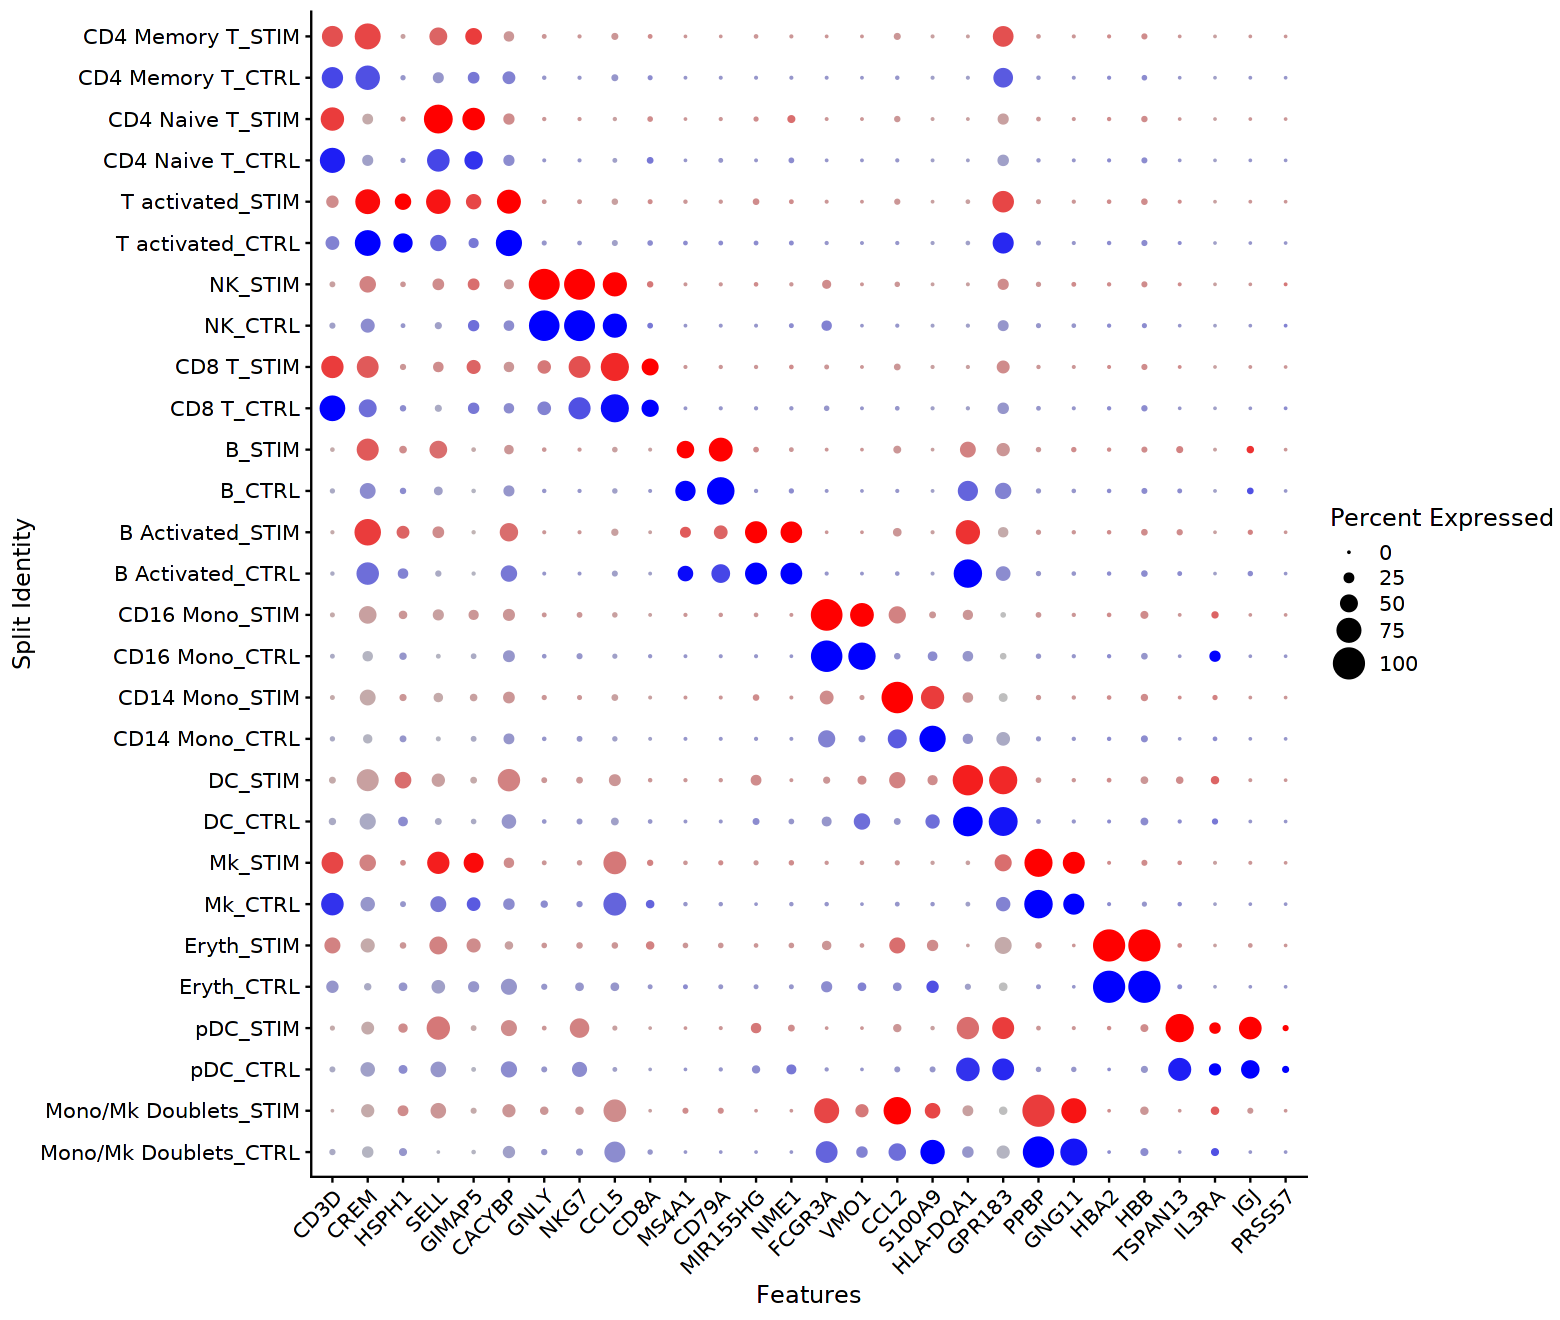

In [33]:
Idents(immune.combined) <- factor(Idents(immune.combined), levels = c("HSPC", "Mono/Mk Doublets",
    "pDC", "Eryth", "Mk", "DC", "CD14 Mono", "CD16 Mono", "B Activated", "B", "CD8 T", "NK", "T activated",
    "CD4 Naive T", "CD4 Memory T"))

markers.to.plot <- c("CD3D", "CREM", "HSPH1", "SELL", "GIMAP5", "CACYBP", "GNLY", "NKG7", "CCL5",
    "CD8A", "MS4A1", "CD79A", "MIR155HG", "NME1", "FCGR3A", "VMO1", "CCL2", "S100A9", "HLA-DQA1",
    "GPR183", "PPBP", "GNG11", "HBA2", "HBB", "TSPAN13", "IL3RA", "IGJ", "PRSS57")

options(repr.plot.width = 13, repr.plot.height = 11)
DotPlot(immune.combined, features = markers.to.plot, cols = c("blue", "red"), dot.scale = 8, split.by = "stim") +
    RotatedAxis()

## Identify differential expressed genes across conditions

Now that we’ve aligned the stimulated and control cells, we can start to do comparative analyses and look at the differences induced by stimulation. One way to look broadly at these changes is to plot the average expression of both the stimulated and control cells and look for genes that are visual outliers on a scatter plot. Here, we take the average expression of both the stimulated and control naive T cells and CD14 monocyte populations and generate the scatter plots, highlighting genes that exhibit dramatic responses to interferon stimulation.

When using repel, set xnudge and ynudge to 0 for optimal results

When using repel, set xnudge and ynudge to 0 for optimal results



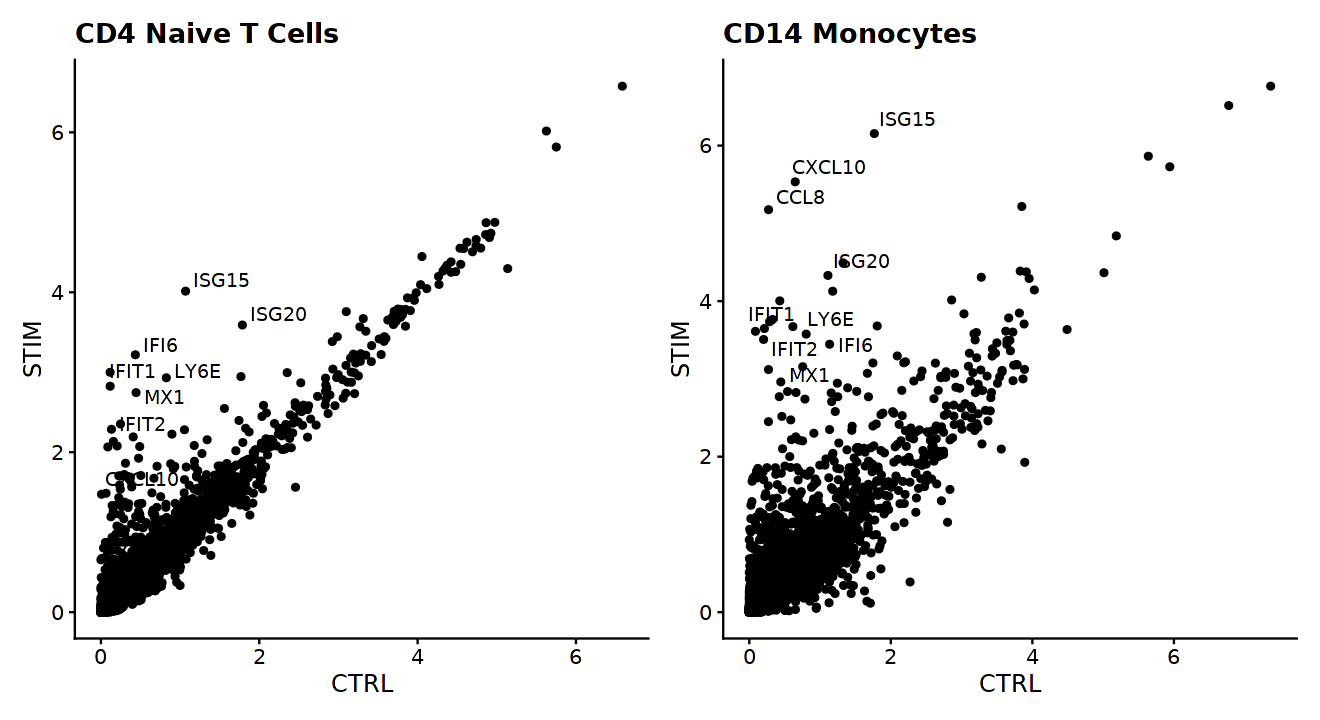

In [37]:
t.cells <- subset(immune.combined, idents = "CD4 Naive T")
Idents(t.cells) <- "stim"
avg.t.cells <- as.data.frame(log1p(AverageExpression(t.cells, verbose = FALSE)$RNA))
avg.t.cells$gene <- rownames(avg.t.cells)

cd14.mono <- subset(immune.combined, idents = "CD14 Mono")
Idents(cd14.mono) <- "stim"
avg.cd14.mono <- as.data.frame(log1p(AverageExpression(cd14.mono, verbose = FALSE)$RNA))
avg.cd14.mono$gene <- rownames(avg.cd14.mono)

genes.to.label = c("ISG15", "LY6E", "IFI6", "ISG20", "MX1", "IFIT2", "IFIT1", "CXCL10", "CCL8")
p1 <- ggplot(avg.t.cells, aes(CTRL, STIM)) + geom_point() + ggtitle("CD4 Naive T Cells")
p1 <- LabelPoints(plot = p1, points = genes.to.label, repel = TRUE)
p2 <- ggplot(avg.cd14.mono, aes(CTRL, STIM)) + geom_point() + ggtitle("CD14 Monocytes")
p2 <- LabelPoints(plot = p2, points = genes.to.label, repel = TRUE)

options(repr.plot.width = 11, repr.plot.height = 6)
p1 + p2

As you can see, many of the same genes are upregulated in both of these cell types and likely represent a conserved interferon response pathway.

Because we are confident in having identified common cell types across condition, we can ask what genes change in different conditions for cells of the same type. First, we create a column in the meta.data slot to hold both the cell type and stimulation information and switch the current ident to that column. Then we use FindMarkers() to find the genes that are different between stimulated and control B cells. Notice that many of the top genes that show up here are the same as the ones we plotted earlier as core interferon response genes. Additionally, genes like CXCL10 which we saw were specific to monocyte and B cell interferon response show up as highly significant in this list as well.

In [38]:
immune.combined$celltype.stim <- paste(Idents(immune.combined), immune.combined$stim, sep = "_")
immune.combined$celltype <- Idents(immune.combined)
Idents(immune.combined) <- "celltype.stim"
b.interferon.response <- FindMarkers(immune.combined, ident.1 = "B_STIM", ident.2 = "B_CTRL", verbose = FALSE)
head(b.interferon.response, n = 15)

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ISG15,1.764781e-155,4.5894588,0.998,0.241,2.480046e-151
IFIT3,3.372820e-151,4.5062474,0.966,0.053,4.739824e-147
IFI6,3.336703e-149,4.2305023,0.966,0.080,4.689069e-145
ISG20,2.188031e-146,2.9346526,1.000,0.674,3.074840e-142
IFIT1,3.125882e-138,4.1322183,0.915,0.033,4.392802e-134
MX1,7.737020e-122,3.3013110,0.908,0.113,1.087283e-117
LY6E,8.565379e-118,3.1243039,0.897,0.153,1.203693e-113
TNFSF10,1.129172e-110,3.8000134,0.793,0.023,1.586825e-106
IFIT2,4.648080e-106,3.6603858,0.786,0.035,6.531947e-102


Another useful way to visualize these changes in gene expression is with the split.by option to the FeaturePlot() or VlnPlot() function. This will display FeaturePlots of the list of given genes, split by a grouping variable (stimulation condition here). Genes such as CD3D and GNLY are canonical cell type markers (for T cells and NK/CD8 T cells) that are virtually unaffected by interferon stimulation and display similar gene expression patterns in the control and stimulated group. IFI6 and ISG15, on the other hand, are core interferon response genes and are upregulated accordingly in all cell types. Finally, CD14 and CXCL10 are genes that show a cell type specific interferon response. CD14 expression decreases after stimulation in CD14 monocytes, which could lead to misclassification in a supervised analysis framework, underscoring the value of integrated analysis. CXCL10 shows a distinct upregulation in monocytes and B cells after interferon stimulation but not in other cell types.

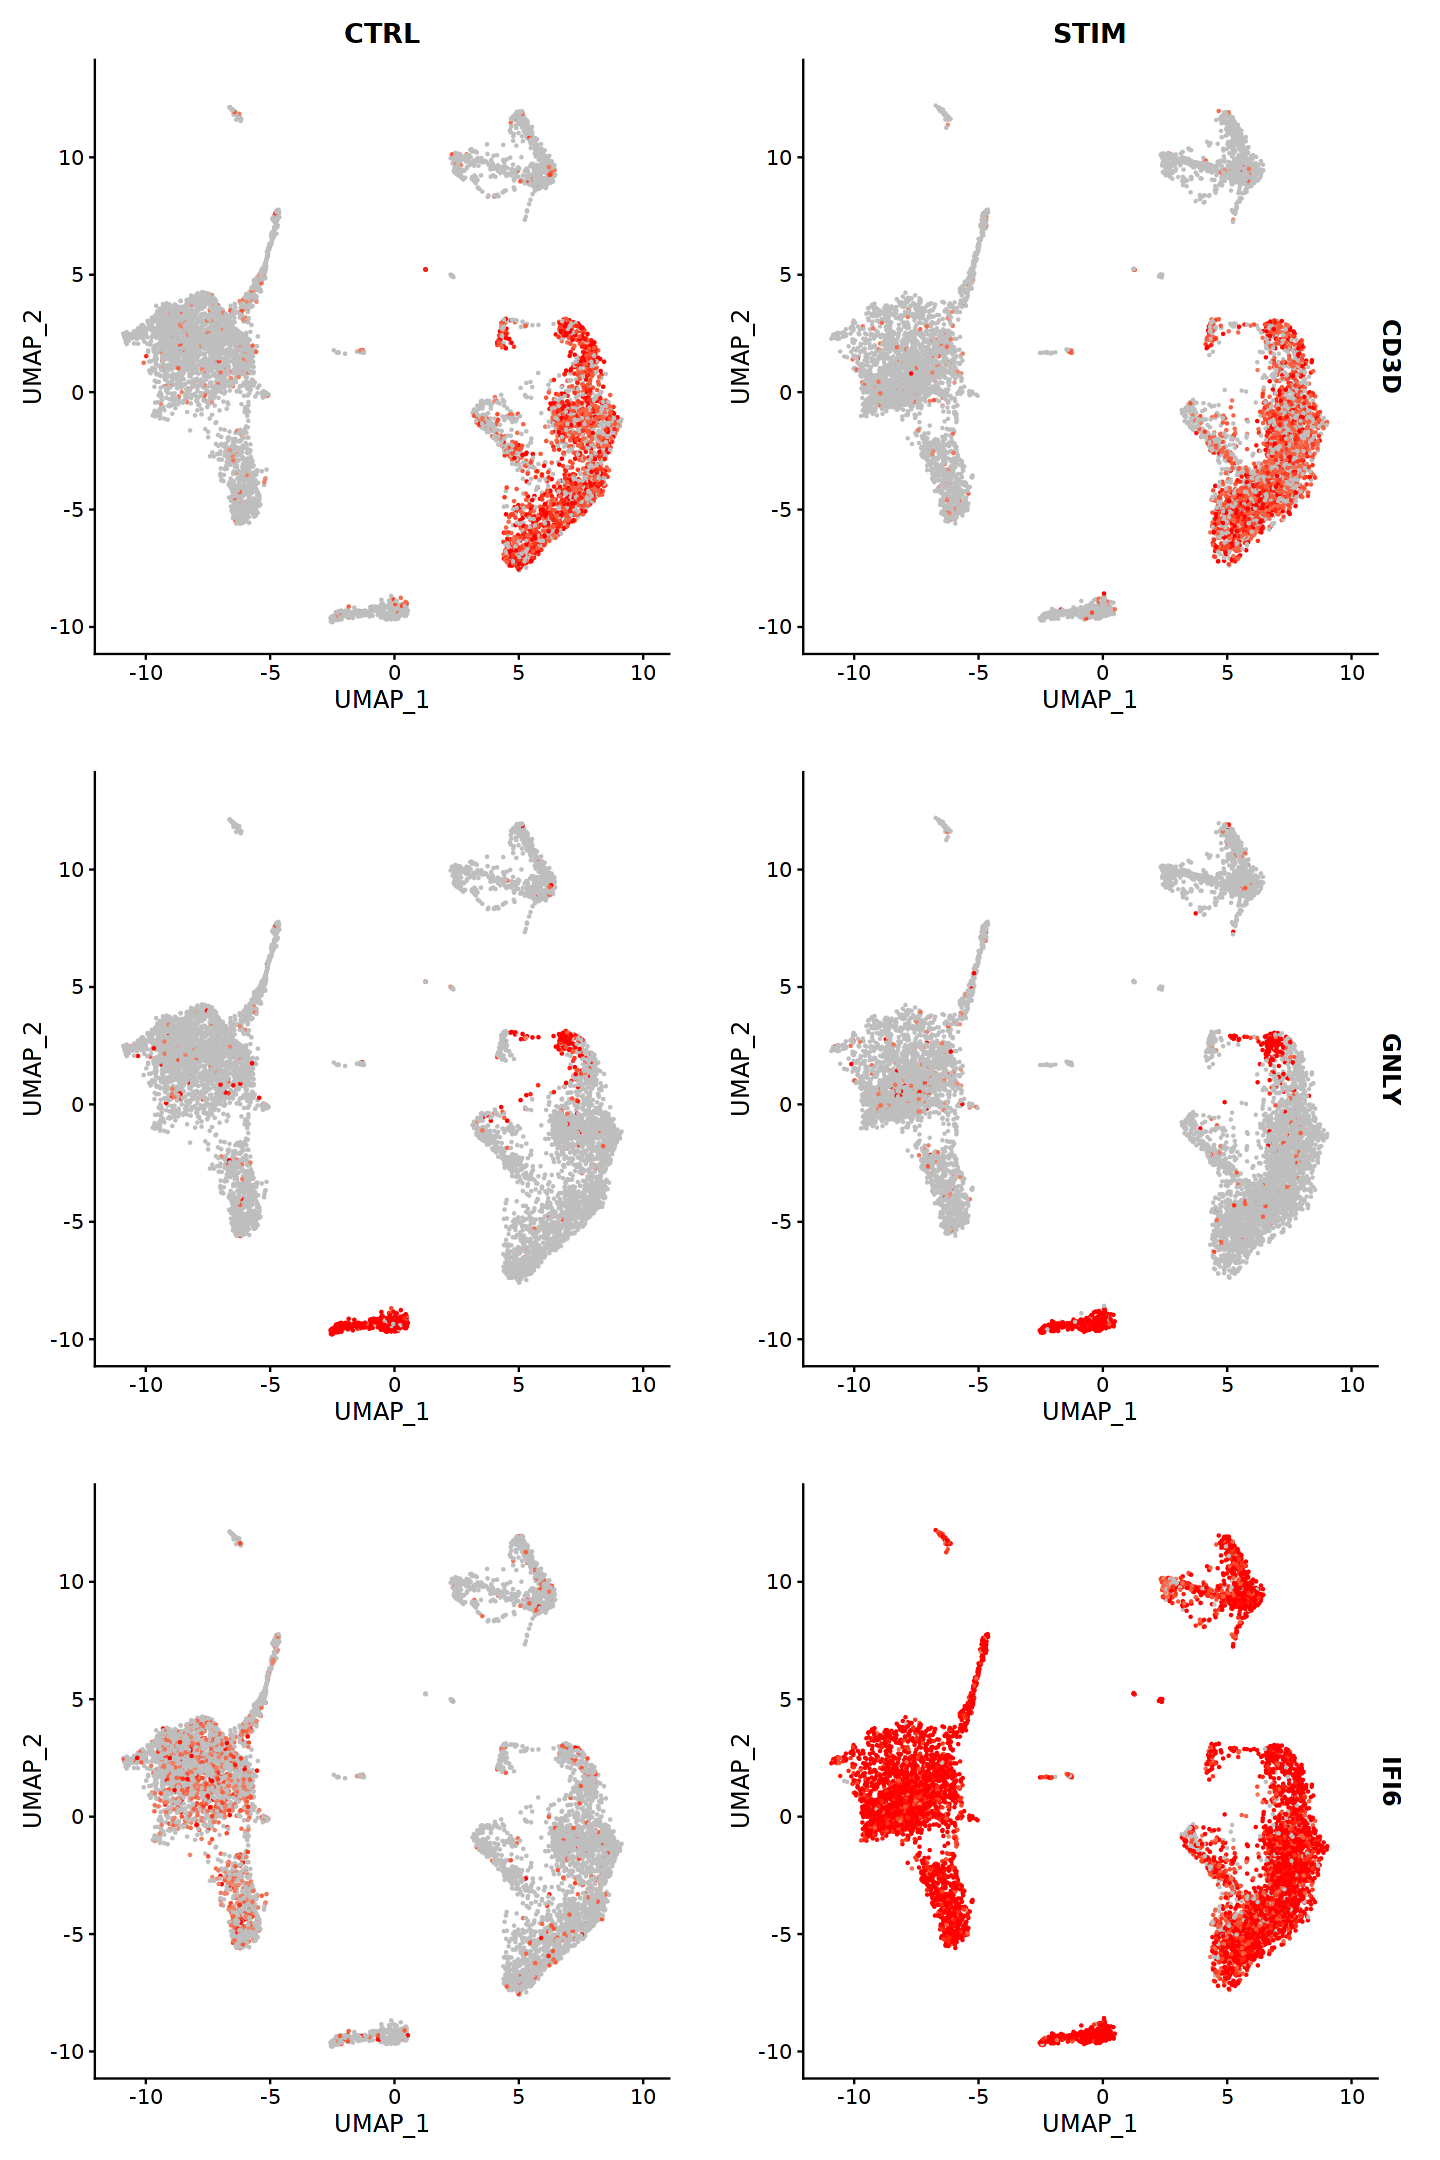

In [40]:
options(repr.plot.width = 12, repr.plot.height = 18)
FeaturePlot(immune.combined, features = c("CD3D", "GNLY", "IFI6"), split.by = "stim", max.cutoff = 3,
    cols = c("grey", "red"))

The default behaviour of split.by has changed.
Separate violin plots are now plotted side-by-side.
To restore the old behaviour of a single split violin,
set split.plot = TRUE.
      
This message will be shown once per session.



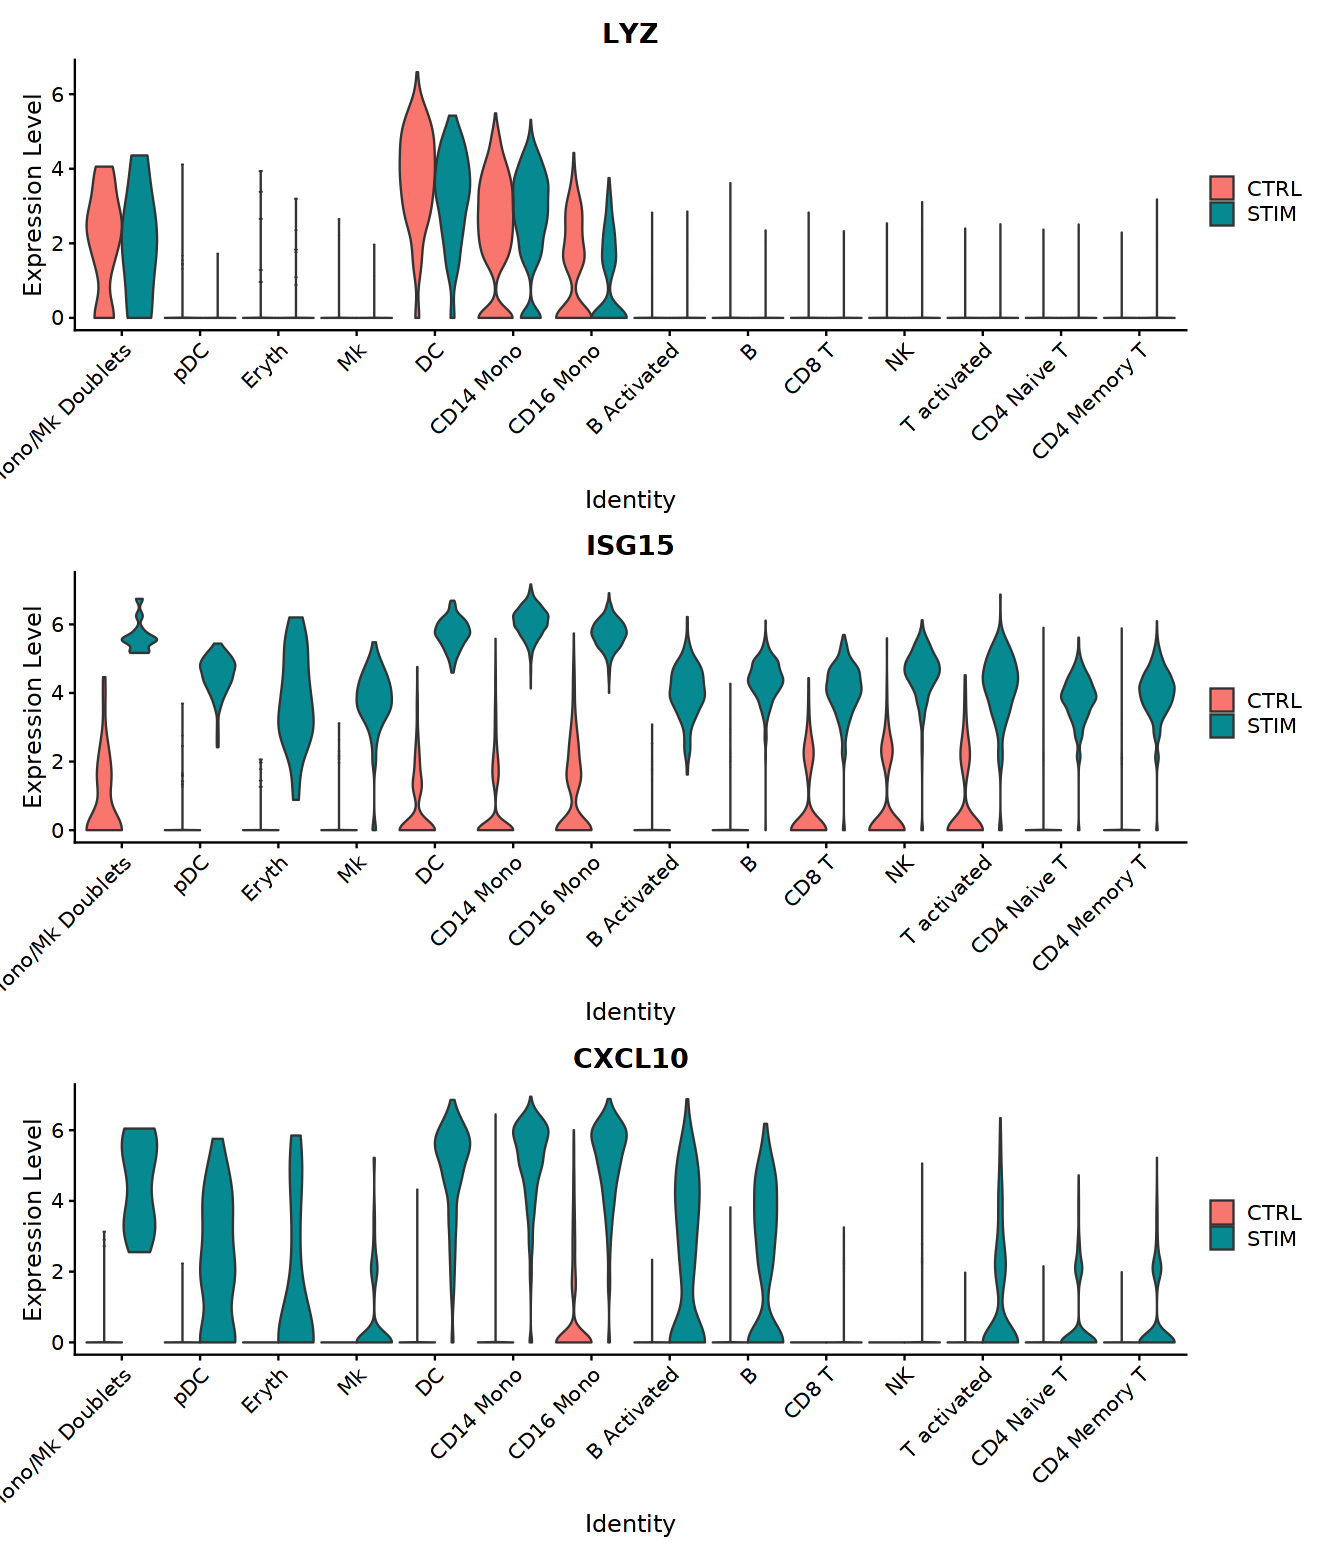

In [41]:
options(repr.plot.width = 11, repr.plot.height = 13)
plots <- VlnPlot(immune.combined, features = c("LYZ", "ISG15", "CXCL10"), split.by = "stim", group.by = "celltype",
    pt.size = 0, combine = FALSE)
wrap_plots(plots = plots, ncol = 1)

# Performing integration on datasets normalized with SCTransform

In Hafemeister and Satija, 2019, we introduced an improved method for the normalization of scRNA-seq, based on regularized negative binomial regression. The method is named ‘sctransform’, and avoids some of the pitfalls of standard normalization workflows, including the addition of a pseudocount, and log-transformation. You can read more about sctransform in the manuscript or our SCTransform vignette.

Below, we demonstrate how to modify the Seurat integration workflow for datasets that have been normalized with the sctransform workflow. The commands are largely similar, with a few key differences:

* Normalize datasets individually by SCTransform(), instead of NormalizeData() prior to integration
* As discussed further in our SCTransform vignette, we typically use 3,000 or more features for analysis downstream of sctransform.
* Run the PrepSCTIntegration() function prior to identifying anchors
* When running FindIntegrationAnchors(), and IntegrateData(), set the normalization.method parameter to the value SCT.
* When running sctransform-based workflows, including integration, do not run the ScaleData() function

In [42]:
LoadData("ifnb")
ifnb.list <- SplitObject(ifnb, split.by = "stim")
ifnb.list <- lapply(X = ifnb.list, FUN = SCTransform)
features <- SelectIntegrationFeatures(object.list = ifnb.list, nfeatures = 3000)
ifnb.list <- PrepSCTIntegration(object.list = ifnb.list, anchor.features = features)

An object of class Seurat 
14053 features across 13999 samples within 1 assay 
Active assay: RNA (14053 features, 0 variable features)

Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 12747 by 6548

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 5000 cells



  |======================================================================| 100%


Found 62 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 12747 genes



  |======================================================================| 100%


Computing corrected count matrix for 12747 genes



  |======================================================================| 100%


Calculating gene attributes

Wall clock passed: Time difference of 2.084046 mins

Determine variable features

Place corrected count matrix in counts slot

Centering data matrix

Set default assay to SCT

Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 12658 by 7451

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 5000 cells



  |======================================================================| 100%


Found 101 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 12658 genes



  |======================================================================| 100%


Computing corrected count matrix for 12658 genes



  |======================================================================| 100%


Calculating gene attributes

Wall clock passed: Time difference of 1.996763 mins

Determine variable features

Place corrected count matrix in counts slot

Centering data matrix

Set default assay to SCT



In [43]:
immune.anchors <- FindIntegrationAnchors(object.list = ifnb.list, normalization.method = "SCT",
    anchor.features = features)
immune.combined.sct <- IntegrateData(anchorset = immune.anchors, normalization.method = "SCT")

Finding all pairwise anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 14759 anchors

Filtering anchors

	Retained 11217 anchors

Merging dataset 1 into 2

Extracting anchors for merged samples

Finding integration vectors

Finding integration vector weights

Integrating data



In [44]:
immune.combined.sct <- RunPCA(immune.combined.sct, verbose = FALSE)
immune.combined.sct <- RunUMAP(immune.combined.sct, reduction = "pca", dims = 1:30)

19:16:14 UMAP embedding parameters a = 0.9922 b = 1.112

19:16:14 Read 13999 rows and found 30 numeric columns

19:16:14 Using Annoy for neighbor search, n_neighbors = 30

19:16:14 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

19:16:17 Writing NN index file to temp file /tmp/Rtmpjh69HS/filedfab4052f20b

19:16:18 Searching Annoy index using 1 thread, search_k = 3000

19:16:24 Annoy recall = 100%

19:16:25 Commencing smooth kNN distance calibration using 1 thread

19:16:26 Initializing from normalized Laplacian + noise

19:16:27 Commencing optimization for 200 epochs, with 601314 positive edges

19:16:35 Optimization finished



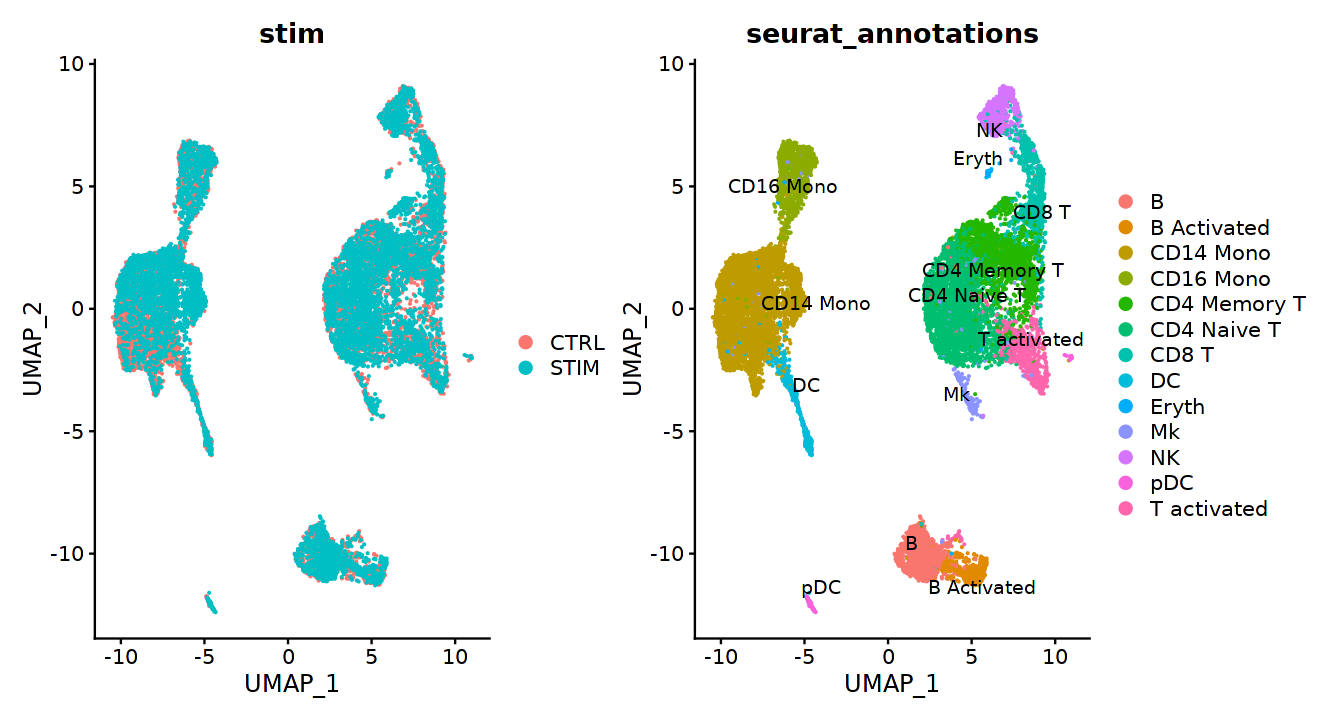

In [46]:
p1 <- DimPlot(immune.combined.sct, reduction = "umap", group.by = "stim")
p2 <- DimPlot(immune.combined.sct, reduction = "umap", group.by = "seurat_annotations", label = TRUE,
    repel = TRUE)

options(repr.plot.width = 11, repr.plot.height = 6)
p1 + p2

## Fast integration using reciprocal PCA (RPCA)
https://satijalab.org/seurat/articles/integration_rpca.html

In this vignette, we present a slightly modified workflow for the integration of scRNA-seq datasets. Instead of utilizing canonical correlation analysis (‘CCA’) to identify anchors, we instead utilize reciprocal PCA (‘RPCA’). When determining anchors between any two datasets using RPCA, we project each dataset into the others PCA space and constrain the anchors by the same mutual neighborhood requirement. The commands for both workflows are largely identical, but the two methods may be applied in different context.

By identifying shared sources of variation between datasets, CCA is well-suited for identifying anchors when cell types are conserved, but there are very substantial differences in gene expression across experiments. CCA-based integration therefore enables integrative analysis when experimental conditions or disease states introduce very strong expression shifts, or when integrating datasets across modalities and species. However, CCA-based integration may also lead to overcorrection, especially when a large proportion of cells are non-overlapping across datasets.

RPCA-based integration runs significantly faster, and also represents a more conservative approach where cells in different biological states are less likely to ‘align’ after integration. We therefore,recommend RPCA during integrative analysis where: * A substantial fraction of cells in one dataset have no matching type in the other * Datasets originate from the same platform (i.e. multiple lanes of 10x genomics) * There are a large number of datasets or cells to integrate (see INSERT LINK for more tips on integrating large datasets)

Below, we demonstrate the use of reciprocal PCA to align the same stimulated and resting datasets first analyzed in our introduction to scRNA-seq integration vignette. While the list of commands is nearly identical, this workflow requires users to run principal components analysis (PCA) individually on each dataset prior to integration. Users should also set the ‘reduction’ argument to ‘rpca’, when running FindIntegrationAnchors().

In [47]:
# load dataset
LoadData("ifnb")

# split the dataset into a list of two seurat objects (stim and CTRL)
ifnb.list <- SplitObject(ifnb, split.by = "stim")

# normalize and identify variable features for each dataset independently
ifnb.list <- lapply(X = ifnb.list, FUN = function(x) {
    x <- NormalizeData(x)
    x <- FindVariableFeatures(x, selection.method = "vst", nfeatures = 2000)
})

# select features that are repeatedly variable across datasets for integration run PCA on each
# dataset using these features
features <- SelectIntegrationFeatures(object.list = ifnb.list)
ifnb.list <- lapply(X = ifnb.list, FUN = function(x) {
    x <- ScaleData(x, features = features, verbose = FALSE)
    x <- RunPCA(x, features = features, verbose = FALSE)
})

An object of class Seurat 
14053 features across 13999 samples within 1 assay 
Active assay: RNA (14053 features, 0 variable features)

## Perform integration


In [ ]:
sessionInfo()